## Documentation

This module implements the statistical mechanical model (Tostesen, 2003) for the denaturation of nucleic acid
sequences. Nearest neighbor stacking interactions and long-range loop entropy are taken into consideration for the computation of partition functions of DNA subchains, which leads to the computation of probability profiles for per-base association. Mean association probability across the whole DNA sequence is then calculated as the helicity at the given temperature. Helicity values at different temperatures are calculated to provide the melting curve of the given sequence. 

1. Recursion algorithm based on Tostesen, 2003. 

2. Thermodynamic parameters are now chosen as in SantaLucia 1998, default DNA oligo model with salt correction, from which stability factors are calculated.

$$s_{ij} = e^{-\frac{\Delta H_{ij} - T \Delta S_{ij}}{RT}}$$ 

$$s_{end} = e^{-\frac{\Delta H_{end} - T \Delta S_{end}}{RT}}$$

$$s_{010} = e^{-2\frac{\Delta H_{end} - T \Delta S_{end}}{RT}}$$

The salt correction currently used is equation 8 or 9 of slunified, 1998.

$$
\Delta S(\text{oligomer}, [Na^+]) = \Delta S(\text{unified oligomer, 1M NaCl}) + 0.368 \times N \times ln[Na^+]
$$

$$
\Delta G_{37}(\text{polymer NN}, [Na^+]) = \Delta G_{37} S(\text{unified NN, 1M NaCl}) -0.175 ln[Na^+] - 0.20
$$

3. $\beta$ -- formation of the first closed base pair. Not sure what value to use. Current value is 1.

4. Loop entropy is calculated based on the power law exact model. The cooperativity (or nucleation or initiation) constant, $\sigma$, and the exponet $\alpha$ are chosen as $\alpha=2.15$ and $\sigma=1.26 \times 10^4$, as in Blossey and Carlon 2003. $\omega_0$ and $\sigma$ are used interchangeably in this module.
Loop entropy
$$\omega_0(j) = \omega_0e^{-\alpha j}$$


Loop entropy exact power law $(O(N^2))$ or multiexponential approximation $(O(N^3))$ : http://stitchprofiles.elixir.no/loopentropy.php


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.Seq import Seq

import figure_setting
from thermodynamics_parameters import df_parameters as df_parameters 
from utilities import helicity, p_closed_profile

In [3]:
## Dispaly thermodynamic parameters used in the calculation, kcal/mol for delta_G_37 and delta_H, kcal/(mol K) for delta_S
df_parameters

,seq,delta_G_37,delta_H,delta_S
0,AA,-1.00,-7.9,-0.0222
1,TT,-1.00,-7.9,-0.0222
2,AT,-0.88,-7.2,-0.0204
3,TA,-0.58,-7.2,-0.0213
4,CA,-1.45,-8.5,-0.0227
5,TG,-1.45,-8.5,-0.0227
6,GT,-1.44,-8.4,-0.0224
7,AC,-1.44,-8.4,-0.0224
8,CT,-1.28,-7.8,-0.0210
9,AG,-1.28,-7.8,-0.0210


In [28]:
## Input sequence

# # A. Generate a random sequence
# np.random.seed(13)
# sequence = "".join(["agct"[base_int] for base_int in np.random.randint(4,size = 100)]).upper()

# # B. Write down a di-block sequence
# sequence = "A"*50 + "G"*50

# C. Umelt example sequence
# sequence = "ACGACGTTGTAAAACGACAGAAGCATAGTATAGAAGAAAAAACAGCGCGCGCGGCGCCAACACATTCAACCTCTGCCACCATGGGGAACTGGGCTGTGAATGAGGGGCTCTCCATTTTTGTCATTGTAAGTACCAACAAGAGATAAGT"
# sequence = "AA"*3
sequence = "ATATATATATATATATGCGCGACGCAGCGT"


# Translate the str object to a Seq object
sequence = Seq(sequence)

# # D. Read in a fasta file. This part does not work yet, because the overflow problem hasn't been solved. 
# file_path = "BC039060.fasta"  # Replace with the actual path to your file
# # Read in the first sequence from the FASTA file using Biopython
# sequence = next(SeqIO.parse(file_path, "fasta")).seq




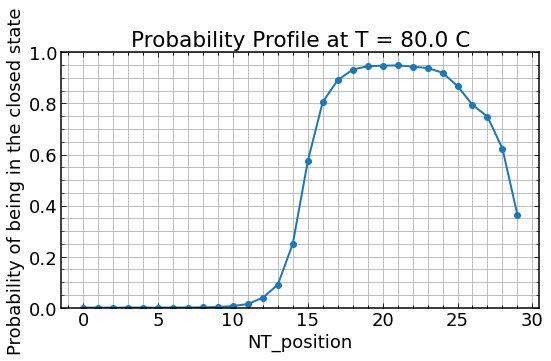

In [29]:
## Plot probability profile under a given temperature
T_plot_profile = 80.

probability_profile = p_closed_profile(sequence, 
                                       T_plot_profile+273., 
                                       model = "SL_oligo",
                                       c_mono = 0.02)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(probability_profile,'o-')
ax.set_xlabel("NT_position")
ax.set_ylabel("Probability of being in the closed state")
ax.set_ylim(0,1)
ax.set_title(f"Probability Profile at T = {T_plot_profile} C")
plt.tight_layout()
# plt.savefig("Probability Profile.png")

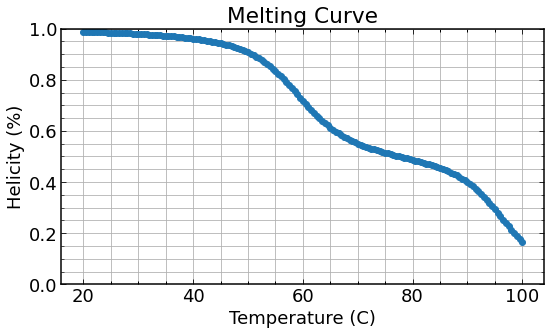

In [30]:
## Plot melting curve
T_low = 20.
T_high = 100.
Ts = np.arange(T_low, T_high+ 0.5, 0.5) + 273 ## change to Kelvin

helicities = helicity(sequence, 
                      Ts,
                      model = "SL_oligo",
                      c_mono = 0.1)
    
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Ts - 273, helicities, 'o-') ## visualization, use Celcius
ax.set_xlabel("Temperature (C)")
ax.set_ylabel("Helicity (%)")
ax.set_ylim(0,1)
ax.set_title(f"Melting Curve")
plt.tight_layout()
# plt.savefig("Melting Curve.png")

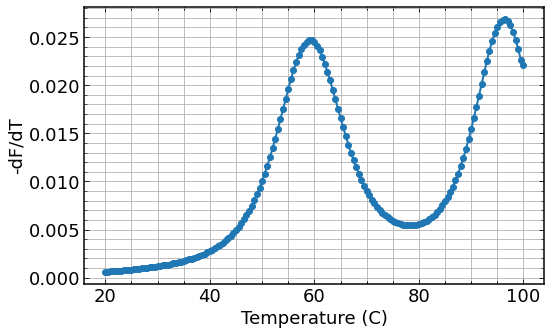

In [31]:
## Plot minus derivative of melting curve
dFdT = np.gradient(helicities, Ts)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Ts - 273, -dFdT, 'o-') ## visualization, use Celcius
ax.set_xlabel("Temperature (C)")
ax.set_ylabel("-dF/dT")
plt.tight_layout()
# plt.savefig("Negative Derivative.png")